In [ ]:
!pip install jax jaxlib
!pip install --quiet --upgrade scipy
!pip install --quiet jax jaxlib optax

In [2]:
import warnings
warnings.filterwarnings("ignore", message="Transparent hugepages are not enabled.*")
import jax
from jax.scipy.stats import norm
import jax.numpy as jnp
from scipy.stats import norm
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, brentq, minimize
from scipy.special import gamma
from numpy.polynomial.legendre import leggauss
import warnings
warnings.filterwarnings('ignore')
from math import log
from numpy.random import default_rng, SeedSequence
from scipy.stats import kstwobign, cramervonmises, uniform
from joblib import Parallel, delayed
from itertools import zip_longest
from collections import OrderedDict
from scipy.stats import uniform, cramervonmises, kstwobign
from joblib import Parallel, delayed
from itertools import zip_longest
import matplotlib.patches as mpatches
import logging
logging.getLogger("matplotlib.backends.backend_ps").setLevel(logging.ERROR)



# ==============================================================
# ETLL ARE Table
# ==============================================================

Computing ARE values for Design B...
Fixed: J₁(1.0, 1.0), varying J₂(a, b)

Table 2: ARE values α=2.0, β=0.5 (Design B)
      0.6   0.7   0.8   1.0   7.0   8.0   9.0   10.0  11.0  12.0
0.3  0.484 0.439 0.022 0.870 0.315 0.271 0.236 0.208 0.184 0.165
0.5  0.527 0.555 0.404 0.910 0.481 0.436 0.399 0.368 0.341 0.317
0.8  0.569 0.653 0.694 0.948 0.663 0.623 0.588 0.558 0.532 0.508
1.0  0.587 0.690 0.775     — 0.750 0.714 0.682 0.655 0.630 0.608
1.2  0.601 0.715 0.818 0.977 0.816 0.784 0.756 0.731 0.709 0.688
2.0  0.630 0.761 0.877 0.999 0.947 0.932 0.917 0.903 0.890 0.877
4.0  0.639 0.768 0.874 0.987 0.838 0.862 0.879 0.890 0.899 0.905
5.0  0.633 0.759 0.861 0.973 0.685 0.727 0.758 0.782 0.801 0.815
7.0  0.619 0.738 0.833 0.942 0.337 0.405 0.458 0.500 0.535 0.564
10.0 0.596 0.706 0.795 0.900 0.089 0.015 0.031 0.052 0.064 0.073

⭐ Maximum ARE = 0.999
   at J₁(1.0,1.0) × J₂(2.0,1.0)


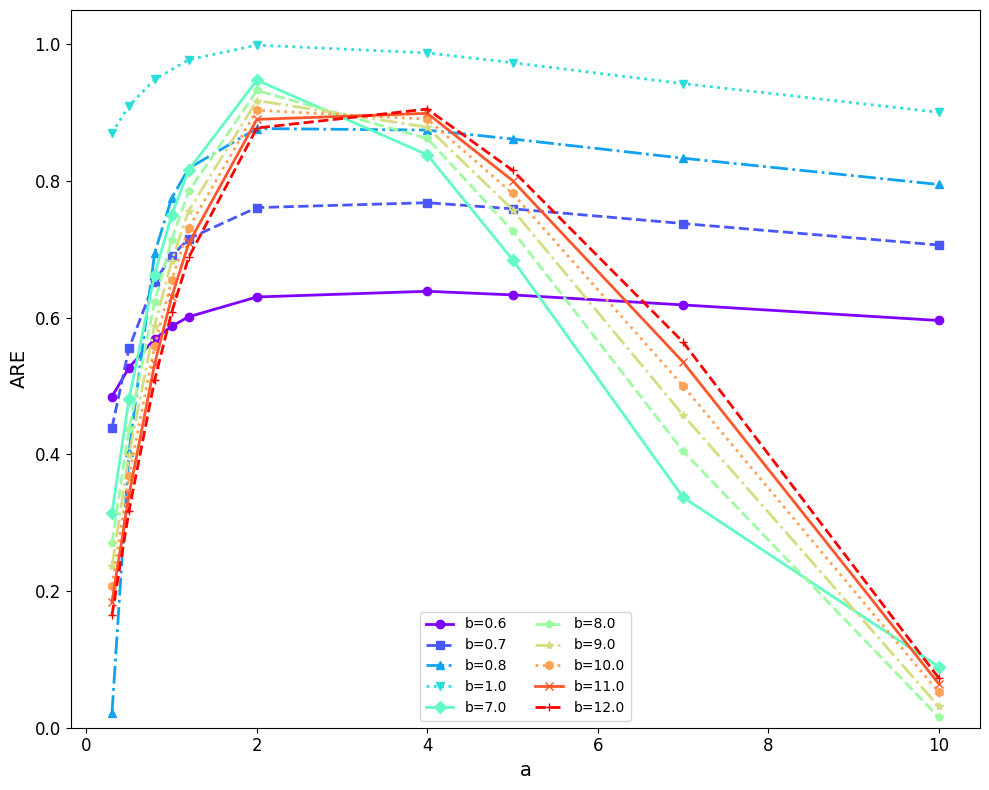


⏱️ Total runtime: 51.01 s


In [3]:
# ==============================================================
# ETLL ARE - Different J (J₁ ≠ J₂), Same h = log(x)
# ==============================================================


pd.set_option("display.width", 2000)
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)

warnings.filterwarnings('ignore')


class ETLLARE_DesignB:
    """Design B: Different J (J₁ ≠ J₂), Same h(x) = log(x)"""

    def __init__(self, theta=1.0, kuma_a1=1.0, kuma_b1=1.0,
                 kuma_a2=1.0, kuma_b2=1.0, n_quad=250):  # Increased from 200
        self.theta = theta
        self.kuma_a1 = kuma_a1
        self.kuma_b1 = kuma_b1
        self.kuma_a2 = kuma_a2
        self.kuma_b2 = kuma_b2
        self.n_quad = n_quad

        nodes, weights = np.polynomial.legendre.leggauss(n_quad)
        self.u = 0.5 * (nodes + 1)
        self.w = 0.5 * weights

    def kumaraswamy_pdf(self, u, a, b):
        """Kumaraswamy PDF with numerical stability"""
        with np.errstate(all='ignore'):
            # Handle extreme parameter cases
            if a > 20 or b > 20:  # Very peaked distributions
                result = a * b * np.exp((a-1)*np.log(u) + (b-1)*np.log(1 - u**a))
            else:
                result = a * b * (u ** (a - 1)) * ((1 - u**a) ** (b - 1))
            return np.nan_to_num(result, nan=0.0, posinf=0.0, neginf=0.0)

    def J1(self, u):
        return self.kumaraswamy_pdf(u, self.kuma_a1, self.kuma_b1)

    def J2(self, u):
        return self.kumaraswamy_pdf(u, self.kuma_a2, self.kuma_b2)

    def compute_cw_k(self, beta, k):
        """Compute c_{w,k}(β) with improved stability"""
        u, w = self.u, self.w
        weights = self.J1(u) if k == 1 else self.J2(u)

        with np.errstate(all='ignore'):
            base = 2**beta - (2**beta - 1) * u
            base = np.maximum(base, 1e-15)

            term = base**(1/beta) - 1
            term = np.maximum(term, 1e-15)

            log_term = np.log(term)
            log_term = np.where(np.isfinite(log_term), log_term, 0.0)

            integrand = weights * log_term

        return np.sum(w * integrand)

    def tau_w(self, beta):
        return self.compute_cw_k(beta, 2) - self.compute_cw_k(beta, 1)

    def solve_beta_robust(self, mu1, mu2):
        """Ultra-robust β solver"""
        Delta_w = mu2 - mu1

        if abs(Delta_w) < 1e-12:
            return np.nan, np.nan

        def Psi(beta):
            try:
                with np.errstate(all='ignore'):
                    c1 = self.compute_cw_k(beta, 1)
                    tau = self.tau_w(beta)

                    if not np.isfinite(c1) or not np.isfinite(tau):
                        return np.nan

                    if abs(tau) < 1e-12:
                        return 1e10 * np.sign(tau + 1e-15)

                    result = (c1 / tau) + (np.log(self.theta) - mu1) / Delta_w
                    return result if np.isfinite(result) else np.nan
            except:
                return np.nan

        # Try multiple strategies with increasing aggressiveness
        strategies = [
            (-2.5, 2.5, 100),
            (-3.0, 3.0, 150),
            (-4.0, 4.0, 200),
            (-5.0, 5.0, 250),
        ]

        for beta_min, beta_max, n_points in strategies:
            try:
                beta_grid = np.linspace(beta_min, beta_max, n_points)
                psi_vals = np.array([Psi(b) for b in beta_grid])

                valid = np.isfinite(psi_vals)
                if np.sum(valid) < 3:
                    continue

                psi_valid = psi_vals[valid]
                beta_valid = beta_grid[valid]

                signs = np.sign(psi_valid)
                sign_changes = np.where(np.diff(signs) != 0)[0]

                if len(sign_changes) == 0:
                    continue

                # Try all sign changes, prefer those closer to 0
                for idx in sign_changes:
                    a, b = beta_valid[idx], beta_valid[idx + 1]

                    fa, fb = Psi(a), Psi(b)
                    if not (np.isfinite(fa) and np.isfinite(fb)):
                        continue

                    if fa * fb < 0:
                        try:
                            beta_hat = brentq(Psi, a, b, xtol=1e-11, rtol=1e-9, maxiter=500)
                            tau = self.tau_w(beta_hat)
                            alpha_hat = -tau / Delta_w

                            # Stricter validation
                            if (alpha_hat > 0.01 and alpha_hat < 100 and
                                np.isfinite(alpha_hat) and abs(beta_hat) < 10):
                                return alpha_hat, beta_hat
                        except:
                            continue
            except:
                continue

        # Final fallback: optimization
        try:
            def objective(beta):
                val = Psi(beta)
                return abs(val) if np.isfinite(val) else 1e10

            result = minimize_scalar(objective, bounds=(-5, 5), method='bounded',
                                    options={'maxiter': 500})

            if result.success and result.fun < 0.001:
                beta_hat = result.x
                tau = self.tau_w(beta_hat)
                alpha_hat = -tau / Delta_w

                if alpha_hat > 0.01 and np.isfinite(alpha_hat):
                    return alpha_hat, beta_hat
        except:
            pass

        return np.nan, np.nan

    def compute_lambda_w(self, ij_type, alpha, beta):
        u, w = self.u, self.w

        if ij_type == '11':
            weights_v = self.J1(u)
            weights_w = self.J1(u)
        elif ij_type == '12':
            weights_v = self.J1(u)
            weights_w = self.J2(u)
        elif ij_type == '22':
            weights_v = self.J2(u)
            weights_w = self.J2(u)
        else:
            raise ValueError("ij_type must be '11', '12', or '22'")

        with np.errstate(all='ignore'):
            base = 2**beta - (2**beta - 1) * u
            base = np.maximum(base, 1e-15)

            term = base**(1/beta) - 1
            term = np.maximum(term, 1e-15)

            g = base**(1/beta - 1) / term
            g = np.where(np.isfinite(g), g, 0.0)

        def K(v, w):
            return np.minimum(v, w) - v * w

        result = 0.0
        for i in range(len(u)):
            for j in range(len(u)):
                integrand = (weights_v[i] * weights_w[j] *
                           K(u[i], u[j]) * g[i] * g[j])
                if np.isfinite(integrand):
                    result += w[i] * w[j] * integrand

        return result

    def compute_variance_covariance(self, alpha, beta):
        with np.errstate(all='ignore'):
            delta = ((2**beta - 1) / (alpha * beta))**2

        if not np.isfinite(delta) or delta <= 0:
            return np.array([[np.nan, np.nan], [np.nan, np.nan]])

        L11 = self.compute_lambda_w('11', alpha, beta)
        L12 = self.compute_lambda_w('12', alpha, beta)
        L22 = self.compute_lambda_w('22', alpha, beta)

        return delta * np.array([[L11, L12], [L12, L22]])

    def fisher_information(self, alpha, beta, n):
        try:
            t = np.linspace(1e-6, 1-1e-6, 540)

            with np.errstate(all='ignore'):
                I_bm1 = np.trapezoid(np.log(t) * (1 + t)**(beta - 1), t)
                I_bm3_2 = np.trapezoid((np.log(t)**2) * (1 + t)**(beta - 3), t)

            two_beta = 2**beta
            denom = two_beta - 1

            Iaa = (1/alpha**2) * (1 - ((beta - 1)/(beta - 2)) *
                  (1 + beta + (beta/denom) * (2*beta*I_bm1 + (beta - 1)*I_bm3_2)))
            Ibb = (1/beta**2) * (1 - (two_beta * beta**2 * (np.log(2)**2)) / (denom**2))
            Iab = (1/(alpha * (beta - 1))) * (1 + (beta * I_bm1) / denom)

            I = n * np.array([[Iaa, Iab], [Iab, Ibb]])

            if np.any(np.linalg.eigvals(I) <= 0):
                return None

            return I
        except:
            return None

    def compute_ARE(self, mu1, mu2, n):
        alpha_hat, beta_hat = self.solve_beta_robust(mu1, mu2)

        if np.isnan(alpha_hat) or np.isnan(beta_hat):
            return np.nan

        try:
            Sigma = self.compute_variance_covariance(alpha_hat, beta_hat) / n

            if np.any(~np.isfinite(Sigma)):
                return np.nan

            eps = 1e-6

            def get_params(m1, m2):
                a, b = self.solve_beta_robust(m1, m2)
                if np.isnan(a) or np.isnan(b):
                    return alpha_hat, beta_hat
                return a, b

            a_p1, b_p1 = get_params(mu1 + eps, mu2)
            a_m1, b_m1 = get_params(mu1 - eps, mu2)
            a_p2, b_p2 = get_params(mu1, mu2 + eps)
            a_m2, b_m2 = get_params(mu1, mu2 - eps)

            D = np.array([
                [(a_p1 - a_m1)/(2*eps), (a_p2 - a_m2)/(2*eps)],
                [(b_p1 - b_m1)/(2*eps), (b_p2 - b_m2)/(2*eps)]
            ])

            if not np.all(np.isfinite(D)) or abs(np.linalg.det(D)) < 1e-12:
                return np.nan

            S_L = D @ Sigma @ D.T

            I = self.fisher_information(alpha_hat, beta_hat, n)
            if I is None:
                return np.nan

            S_MLE = np.linalg.inv(I)

            det_S_L = np.linalg.det(S_L)
            det_S_MLE = np.linalg.det(S_MLE)

            if det_S_L <= 0 or det_S_MLE <= 0 or not np.isfinite(det_S_L) or not np.isfinite(det_S_MLE):
                return np.nan

            ARE = np.sqrt(det_S_MLE / det_S_L)

            # Stricter sanity check
            if not np.isfinite(ARE) or ARE < 1e-6 or ARE > 2:
                return np.nan

            return ARE
        except:
            return np.nan


def generate_etll_are_table_and_plot(alpha_true=2.0, beta_true=0.5, n=1000):
    a_values = [0.3, 0.5, 0.8, 1.0, 1.2, 2.0, 4.0, 5.0, 7.0, 10.0]
    b_values = [0.6, 0.7, 0.8, 1.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]

    are_matrix = np.zeros((len(a_values), len(b_values)))

    print("Computing ARE values for Design B...")
    print(f"Fixed: J₁(1.0, 1.0), varying J₂(a, b)")
    print("="*70)

    for i, a in enumerate(a_values):
        for j, b in enumerate(b_values):
            if a == 1.0 and b == 1.0:
                are_matrix[i, j] = -1.0
                continue


            solver = ETLLARE_DesignB(theta=1.0, kuma_a1=1.0, kuma_b1=1.0,
                                      kuma_a2=a, kuma_b2=b, n_quad=250)

            u, w = solver.u, solver.w

            with np.errstate(all='ignore'):
                q = 1.0 * ((2**beta_true - (2**beta_true - 1) * u)**(1/beta_true) - 1)**(-1/alpha_true)

            weights1 = solver.J1(u)
            weights2 = solver.J2(u)

            mu1 = np.sum(w * weights1 * np.log(q))
            mu2 = np.sum(w * weights2 * np.log(q))

            are = solver.compute_ARE(mu1, mu2, n)
            are_matrix[i, j] = are

    # Create DataFrame
    df = pd.DataFrame(are_matrix, index=a_values, columns=b_values)

    # Replace failures with special marker
    df_display = df.copy()
    df_for_print = df.replace(-1.0, np.nan)   # Excluded case

    print("\n" + "="*70)
    print("Table 2: ARE values α=2.0, β=0.5 (Design B)")
    print("="*70)
    print(df_for_print.to_string(
    float_format=lambda x: f"{x:.3f}",  # 3 decimals everywhere
    na_rep='—'                          # show em-dash for excluded cell
    ))

    # Find max ARE
    valid_ares = are_matrix[(are_matrix > 0.01) & np.isfinite(are_matrix)]

    if len(valid_ares) > 0:
        max_are = np.max(valid_ares)

        max_locations = []
        for i, a in enumerate(a_values):
            for j, b in enumerate(b_values):
                if np.isfinite(are_matrix[i, j]) and abs(are_matrix[i, j] - max_are) < 1e-6:
                    max_locations.append((a, b))

        print(f"\n⭐ Maximum ARE = {max_are:.3f}")
        if len(max_locations) == 1:
            print(f"   at J₁(1.0,1.0) × J₂({max_locations[0][0]},{max_locations[0][1]})")
        else:
            print(f"   Found at {len(max_locations)} locations:")
            for a, b in max_locations:
                print(f"   • J₂({a},{b})")

    # Count failures
    nan_count = np.sum(np.isnan(are_matrix[are_matrix != -1.0]))
    zero_count = np.sum((are_matrix > -0.5) & (are_matrix < 0.01))

    if nan_count > 0:
        print(f"\n⚠️  NaN values: {nan_count}")
        for i, a in enumerate(a_values):
            for j, b in enumerate(b_values):
                if np.isnan(are_matrix[i, j]):
                    print(f"   • J₂({a},{b})")

    if zero_count > 0:
        print(f"\n⚠️  Near-zero values (< 0.01): {zero_count}")
        for i, a in enumerate(a_values):
            for j, b in enumerate(b_values):
                are = are_matrix[i, j]
                if 0 < are < 0.01:
                    print(f"   • J₂({a},{b}): {are:.6f}")

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))

    colors = plt.cm.rainbow(np.linspace(0, 1, len(b_values)))
    linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--']
    markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'x', '+']

    a_arr = np.array(a_values)

    for j, b in enumerate(b_values):
        col = are_matrix[:, j]
        # keep only “good” points:
        #   - finite
        #   - not the J1 = J2 marker (-1.0)
        #   - not near-zero failures (< 0.01)
        valid = (
            np.isfinite(col) &
            (col != -1.0) &
            (col > 0.01)
        )

        x = a_arr[valid]
        y = col[valid]

        ax.plot(
            x, y,
            linestyle=linestyles[j],
            marker=markers[j],
            markersize=6,
            linewidth=2,
            color=colors[j],
            label=f"b={b}"
        )

    ax.set_xlabel("a", fontsize=14)
    ax.set_ylabel("ARE", fontsize=14)
    ax.set_ylim(0, 1.05)
    ax.grid(False)
    ax.legend(loc="best", ncol=2, fontsize=10)
    ax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.savefig("etll_are_interaction_designB.pdf", dpi=300, bbox_inches='tight')
    plt.savefig("etll_are_interaction_designB.png", dpi=300, bbox_inches='tight')
    plt.savefig("etll_are_interaction_designB.eps", dpi=300, bbox_inches='tight')
    plt.show()

    return df, are_matrix


if __name__ == "__main__":
    t0 = time.perf_counter()
    df, mat = generate_etll_are_table_and_plot()
    dt = time.perf_counter() - t0
    print(f"\n⏱️ Total runtime: {dt:.2f} s")